<a href="https://colab.research.google.com/github/atharvakale343/682-final-project/blob/main/experiments_cnns.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
!pip install imagehash Pillow

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 296.7/296.7 kB 7.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 4.5/4.5 MB 27.5 MB/s eta 0:00:00


In [2]:
from google.colab import drive
drive.mount('/content/drive')
from pathlib import Path

# !unzip "/content/drive/MyDrive/cs682/archive" &> /dev/null

Mounted at /content/drive


In [3]:
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader
from torch.utils.data import sampler

import torchvision.datasets as dset
import torchvision.transforms as T
import torch.nn.functional as F
from torchvision import datasets, transforms
import torchvision

import numpy as np

In [4]:
USE_GPU = True

dtype = torch.float16 # we will be using float throughout this tutorial

if USE_GPU and torch.cuda.is_available():
    device = torch.device('cuda')
else:
    device = torch.device('cpu')

# Constant to control how frequently we print train loss
print_every = 2

print('using device:', device)

using device: cuda


In [5]:
import torchvision.datasets as dset
from torch.utils.data import DataLoader, Subset, random_split
from PIL import Image
import numpy as np
import imagehash
import torchvision.transforms as transforms
import torch
import torch.nn as nn
from tqdm import tqdm

# Device
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# Define image transforms
transform = transforms.Compose([
    transforms.Resize((224, 224)),  # Resize to a consistent size
    transforms.ToTensor(),          # Convert PIL Image to tensor
    transforms.Normalize([0.5]*3, [0.5]*3)  # Normalize for 3-channel image
])

# Wrapper to add precomputed perceptual hash to dataset
class CIFAR10WithHash(torch.utils.data.Dataset):
    def __init__(self, base_dataset, hash_size=8):
        self.base_dataset = base_dataset
        self.hash_size = hash_size
        self.hash_dim = hash_size * hash_size
        self.cached_data = []

        to_pil = transforms.ToPILImage()
        print("Precomputing hashes...")
        for img_tensor, label in tqdm(base_dataset, desc="Hashing images"):
            pil_img = to_pil((img_tensor * 0.5 + 0.5).clamp(0, 1))  # Undo normalization
            phash = imagehash.average_hash(pil_img, hash_size=hash_size)
            # phash = imagehash.phash(pil_img, hash_size=hash_size)
            hash_vector = np.array(phash.hash, dtype=np.float16).flatten()
            hash_tensor = torch.tensor(hash_vector, dtype=dtype)
            self.cached_data.append((img_tensor, hash_tensor, label))
        print("Done precomputing hashes.")

    def __len__(self):
        return len(self.cached_data)

    def __getitem__(self, idx):
        return self.cached_data[idx]

# Load base datasets
train_base = dset.CIFAR10('./cs682/datasets', train=True, download=True, transform=transform)
test_base = dset.CIFAR10('./cs682/datasets', train=False, download=True, transform=transform)

# Subsample first 2000 for train+val
subset_train_base = Subset(train_base, list(range(4000)))
train_base, val_base = random_split(subset_train_base, [3200, 800], generator=torch.Generator().manual_seed(42))
test_base = Subset(test_base, list(range(2000)))

# Wrap with hash-augmented datasets
train_dataset = CIFAR10WithHash(train_base)
val_dataset = CIFAR10WithHash(val_base)
test_dataset = CIFAR10WithHash(test_base)

# Create dataloaders
train_loader = DataLoader(train_dataset, batch_size=400, shuffle=True, num_workers=2)
val_loader = DataLoader(val_dataset, batch_size=400, shuffle=False, num_workers=2)
test_loader = DataLoader(test_dataset, batch_size=400, shuffle=False, num_workers=2)



100%|██████████| 170M/170M [00:17<00:00, 9.49MB/s]


Precomputing hashes...


Hashing images: 100%|██████████| 3200/3200 [00:11<00:00, 267.88it/s]


Done precomputing hashes.
Precomputing hashes...


Hashing images: 100%|██████████| 800/800 [00:02<00:00, 293.31it/s]


Done precomputing hashes.
Precomputing hashes...


Hashing images: 100%|██████████| 2000/2000 [00:07<00:00, 269.00it/s]

Done precomputing hashes.


In [6]:

# Optional: get class names
class_names = train_base.dataset.dataset.classes
print("Classes:", class_names)

Classes: ['airplane', 'automobile', 'bird', 'cat', 'deer', 'dog', 'frog', 'horse', 'ship', 'truck']


Preprocessing Data

In [ ]:
# prompt: display some images of each class from cifar 10 dataset

import matplotlib.pyplot as plt
import numpy as np

# functions to show an image
def imshow(img):
    img = img / 2 + 0.5     # unnormalize
    npimg = img.numpy()
    plt.imshow(np.transpose(npimg, (1, 2, 0)))
    plt.show()


# get some random training images
dataiter = iter(train_loader)
images, _, labels = next(dataiter)

# show images
imshow(torchvision.utils.make_grid(images[:4]))
# print labels
print(' '.join('%5s' % class_names[labels[j]] for j in range(4)))


In [ ]:
def check_accuracy_part34(loader, model, is_train=True):
    if is_train:
        print('Checking accuracy on validation set')
    else:
        print('Checking accuracy on test set')
    num_correct = 0
    num_samples = 0
    model.eval()  # set model to evaluation mode
    with torch.no_grad():
        for x, hash, y in loader:
            x = x.to(device=device, dtype=dtype)  # move to device, e.g. GPU
            y = y.to(device=device, dtype=torch.long)
            scores = model(x)
            _, preds = scores.max(1)
            num_correct += (preds == y).sum()
            num_samples += preds.size(0)
        acc = float(num_correct) / num_samples
        print('Got %d / %d correct (%.2f)' % (num_correct, num_samples, 100 * acc))

In [ ]:

def train_part34(model, optimizer, tr_loader, val_loader, epochs=1):
    """
    Train a model on CIFAR-10 using the PyTorch Module API.

    Inputs:
    - model: A PyTorch Module giving the model to train.
    - optimizer: An Optimizer object we will use to train the model
    - epochs: (Optional) A Python integer giving the number of epochs to train for

    Returns: Nothing, but prints model accuracies during training.
    """
    model = model.to(device=device)  # move the model parameters to CPU/GPU
    for e in range(epochs):
        for t, (x, hash, y) in enumerate(tr_loader):
            model.train()  # put model to training mode
            x = x.to(device=device, dtype=dtype)  # move to device, e.g. GPU
            y = y.to(device=device, dtype=torch.long)

            scores = model(x)
            loss = F.cross_entropy(scores, y)

            # Zero out all of the gradients for the variables which the optimizer
            # will update.
            optimizer.zero_grad()

            # This is the backwards pass: compute the gradient of the loss with
            # respect to each  parameter of the model.
            loss.backward()

            # Actually update the parameters of the model using the gradients
            # computed by the backwards pass.
            optimizer.step()

            if t % print_every == 0:
                print('Iteration %d, loss = %.4f' % (t, loss.item()))
                check_accuracy_part34(val_loader, model, is_train=True)
                print()

In [7]:
# prompt: use resnet 18 to do image classification of cifar-10. use test set to get accuracy

import torch.nn as nn
import torchvision.models as models

# Load a pre-trained ResNet18 model
model = models.resnet18(pretrained=True)

# Modify the final fully connected layer for 10 classes (CIFAR-10)
num_ftrs = model.fc.in_features
model.fc = nn.Linear(num_ftrs, 10)

# Move the model to the appropriate device
model = model.to(device, dtype=dtype)
USING_HASH_MODEL = False

# Define loss function and optimizer
criterion = nn.CrossEntropyLoss()
optimizer = optim.SGD(model.parameters(), lr=0.001, momentum=0.9)

/usr/local/lib/python3.11/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet18_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet18_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)
Downloading: "https://download.pytorch.org/models/resnet18-f37072fd.pth" to /root/.cache/torch/hub/checkpoints/resnet18-f37072fd.pth
100%|██████████| 44.7M/44.7M [00:00<00:00, 168MB/s]


In [ ]:
# Training loop (example - adjust as needed)
num_epochs = 20
model.train()
train_part34(model, optimizer, train_loader, val_loader, epochs=num_epochs)

# Evaluation on the test set
correct = 0
total = 0
model.eval()  # set model to evaluation mode
with torch.no_grad():
    for images, hash_tensors, labels in test_loader:
        images = images.to(device, dtype=dtype)
        hash_tensors = hash_tensors.to(device, dtype=dtype)
        labels = labels.to(device)

        outputs = model(images)
        _, predicted = torch.max(outputs.data, 1)
        total += labels.size(0)
        correct += (predicted == labels).sum().item()

accuracy = 100 * correct / total
print(f"Test Accuracy: {accuracy:.2f}%")


Iteration 0, loss = 0.4114
Checking accuracy on validation set
Got 656 / 800 correct (82.00)

Iteration 0, loss = 0.3662
Checking accuracy on validation set
Got 661 / 800 correct (82.62)

Iteration 0, loss = 0.3904
Checking accuracy on validation set
Got 655 / 800 correct (81.88)

Iteration 0, loss = 0.3396
Checking accuracy on validation set
Got 666 / 800 correct (83.25)

Iteration 0, loss = 0.3257
Checking accuracy on validation set
Got 665 / 800 correct (83.12)

Iteration 0, loss = 0.3079
Checking accuracy on validation set
Got 665 / 800 correct (83.12)

Iteration 0, loss = 0.2603
Checking accuracy on validation set
Got 666 / 800 correct (83.25)

Iteration 0, loss = 0.2856
Checking accuracy on validation set
Got 670 / 800 correct (83.75)

Iteration 0, loss = 0.3167
Checking accuracy on validation set
Got 670 / 800 correct (83.75)

Iteration 0, loss = 0.2817
Checking accuracy on validation set
Got 668 / 800 correct (83.50)

Iteration 0, loss = 0.2778
Checking accuracy on validation s

In [8]:
def check_accuracy_hashes(loader, model, is_train=False):
    model.eval()
    num_correct = 0
    num_samples = 0

    with torch.no_grad():
        for x, h, y in loader:
            x = x.to(device=device, dtype=dtype)
            h = h.to(device=device, dtype=dtype)
            y = y.to(device=device, dtype=torch.long)

            scores = model(x, h)
            _, preds = scores.max(1)
            num_correct += (preds == y).sum().item()
            num_samples += y.size(0)

    acc = 100.0 * num_correct / num_samples
    if is_train:
        print(f"Training Accuracy: {acc:.2f}%")
    else:
      print(f"Validation Accuracy: {acc:.2f}%\n")
    return acc


In [9]:
def train_part34_hashes(model, optimizer, scheduler, tr_loader, val_loader, epochs=1, print_every=2):
    """
    Train a model on CIFAR-10 using the PyTorch Module API, with perceptual hashes.

    Inputs:
    - model: A PyTorch Module that takes (image_tensor, hash_tensor) and returns logits.
    - optimizer: A PyTorch Optimizer for updating model parameters.
    - tr_loader: DataLoader for the training data (yields (x, h, y))
    - val_loader: DataLoader for validation data (same format as tr_loader)
    - epochs: (Optional) Number of epochs to train for
    - print_every: (Optional) How often to print training status

    Returns: Nothing, but prints model loss and accuracy during training.
    """
    model = model.to(device=device)

    for e in range(epochs):
        print(f"Epoch {e + 1}/{epochs}")
        model.train()
        for t, (x, h, y) in enumerate(tr_loader):
            x = x.to(device=device, dtype=dtype)
            h = h.to(device=device, dtype=dtype)
            y = y.to(device=device, dtype=torch.long)

            scores = model(x, h)
            loss = F.cross_entropy(scores, y)

            optimizer.zero_grad()
            loss.backward()
            optimizer.step()

            if t % print_every == 0:
                print(f"Iteration {t}, loss = {loss.item():.4f}")
                print()
        # Compute and print training accuracy
        check_accuracy_hashes(tr_loader, model, is_train=True)

        # Optional: run validation at the end of each epoch
        val_acc = check_accuracy_hashes(val_loader, model)
        scheduler.step(val_acc)

In [10]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import torchvision.models as models
import torchvision.transforms as transforms
import imagehash
from PIL import Image
import numpy as np
from torch.optim.lr_scheduler import ReduceLROnPlateau

class ResNetWithHash(nn.Module):
    def __init__(self, base_model, hash_size=8, num_classes=10):
        super(ResNetWithHash, self).__init__()
        self.resnet = nn.Sequential(*list(base_model.children())[:-1])  # up to avgpool
        self.resnet_fc_in = base_model.fc.in_features

        self.hash_size = hash_size
        self.hash_dim = hash_size * hash_size  # e.g., 64

        # 🔧 MLP projection for hash vector
        self.hash_proj = nn.Sequential(
            nn.Linear(self.hash_dim, 128),
            nn.ReLU(),
            nn.Linear(128, 128),
            nn.ReLU()
        )

        # Final classifier takes projected hash + CNN features
        self.fc = nn.Linear(self.resnet_fc_in + 128, num_classes)

    def forward(self, x, hash_tensor):
        features = self.resnet(x).view(x.size(0), -1)
        hash_tensor = hash_tensor.to(x.device)

        # Project hash using MLP
        hash_features = self.hash_proj(hash_tensor)

        # Concatenate and classify
        combined = torch.cat((features, hash_features), dim=1)
        return self.fc(combined)

# Load a pre-trained ResNet18 model
base_model = models.resnet18(pretrained=True)
model = ResNetWithHash(base_model)
USING_HASH_MODEL = True

# Modify the final fully connected layer for 10 classes (CIFAR-10)
num_ftrs = model.fc.in_features
model.fc = nn.Linear(num_ftrs, 10)

# Move the model to the appropriate device
model = model.to(device, dtype=dtype)

# Define loss function and optimizer
criterion = nn.CrossEntropyLoss()
optimizer = optim.SGD(model.parameters(), lr=0.001, momentum=0.9)
scheduler = ReduceLROnPlateau(optimizer, mode='max', factor=0.5, patience=2, verbose=True)


/usr/local/lib/python3.11/dist-packages/torch/optim/lr_scheduler.py:62: UserWarning: The verbose parameter is deprecated. Please use get_last_lr() to access the learning rate.
  warnings.warn(


In [ ]:
# Training loop (example - adjust as needed)
num_epochs = 20
model.train()
train_part34_hashes(model, optimizer, scheduler, train_loader, val_loader, epochs=num_epochs)

# Evaluation on the test set
correct = 0
total = 0
model.eval()  # set model to evaluation mode
with torch.no_grad():
    for images, hash_tensors, labels in test_loader:
        images = images.to(device, dtype=dtype)
        hash_tensors = hash_tensors.to(device, dtype=dtype)
        labels = labels.to(device)

        outputs = model(images, hash_tensors)
        _, predicted = torch.max(outputs.data, 1)
        total += labels.size(0)
        correct += (predicted == labels).sum().item()

accuracy = 100 * correct / total
print(f"Test Accuracy: {accuracy:.2f}%")


Epoch 1/20
Iteration 0, loss = 2.4668

Iteration 2, loss = 2.4551

Iteration 4, loss = 2.3711

Iteration 6, loss = 2.3418

Training Accuracy: 10.66%
Validation Accuracy: 12.38%

Epoch 2/20
Iteration 0, loss = 2.2695

Iteration 2, loss = 2.2695

Iteration 4, loss = 2.2227

Iteration 6, loss = 2.1504

Training Accuracy: 26.06%
Validation Accuracy: 26.00%

Epoch 3/20
Iteration 0, loss = 2.0840

Iteration 2, loss = 2.0176

Iteration 4, loss = 1.9609

Iteration 6, loss = 1.9062

Training Accuracy: 44.09%
Validation Accuracy: 40.50%

Epoch 4/20
Iteration 0, loss = 1.8398

Iteration 2, loss = 1.7705

Iteration 4, loss = 1.7197

Iteration 6, loss = 1.6738

Training Accuracy: 54.50%
Validation Accuracy: 52.62%

Epoch 5/20
Iteration 0, loss = 1.5918

Iteration 2, loss = 1.5410

Iteration 4, loss = 1.5498

Iteration 6, loss = 1.4785

Training Accuracy: 62.75%
Validation Accuracy: 61.25%

Epoch 6/20
Iteration 0, loss = 1.4160

Iteration 2, loss = 1.4287

Iteration 4, loss = 1.3408

Iteration 6, lo

In [ ]:
# prompt: save the model checkpoint in google drive

# Save the model checkpoint to Google Drive
checkpoint_path = '/content/drive/MyDrive/cs682/resnet18_cifar10_checkpoint_smallds_original.pth'
# checkpoint_path = '/content/drive/MyDrive/cs682/resnet18_cifar10_checkpoint_phash.pth'
torch.save({
    'epoch': num_epochs,
    'model_state_dict': model.state_dict(),
    'optimizer_state_dict': optimizer.state_dict(),
}, checkpoint_path)

print(f"Model checkpoint saved to: {checkpoint_path}")


Model checkpoint saved to: /content/drive/MyDrive/cs682/resnet18_cifar10_checkpoint_smallds_original.pth


In [ ]:
# prompt: load the model from checkpoint stored at /content/drive/MyDrive/cs682/resnet18_cifar10_checkpoint.pth into a variable called `model`

# checkpoint = torch.load('/content/drive/MyDrive/cs682/resnet18_cifar10_checkpoint_phash.pth')
# checkpoint = torch.load('/content/drive/MyDrive/cs682/resnet18_cifar10_checkpoint.pth')
checkpoint = torch.load('/content/drive/MyDrive/cs682/resnet18_cifar10_checkpoint_smallds_original.pth')
model.load_state_dict(checkpoint['model_state_dict'])
optimizer.load_state_dict(checkpoint['optimizer_state_dict'])
epoch = checkpoint['epoch']
print(f"Loaded model from epoch {epoch}")


Loaded model from epoch 20


In [ ]:
import torch
import torch.nn.functional as F

def fgsm_attack(image, epsilon, data_grad):
    sign_data_grad = data_grad.sign()
    perturbed_image = image + epsilon * sign_data_grad
    return torch.clamp(perturbed_image, 0, 1)

def pgd_attack(model, image, hash, target, epsilon, alpha=0.01, iters=10):
    perturbed_image = image.clone().detach().to(image.device)
    perturbed_image.requires_grad = True

    for _ in range(iters):
        output = model(perturbed_image, hash)
        loss = F.cross_entropy(output, target)
        model.zero_grad()
        loss.backward()

        with torch.no_grad():
            grad_sign = perturbed_image.grad.sign()
            perturbed_image = perturbed_image + alpha * grad_sign
            delta = torch.clamp(perturbed_image - image, min=-epsilon, max=epsilon)
            perturbed_image = torch.clamp(image + delta, 0, 1).detach()
            perturbed_image.requires_grad = True

    return perturbed_image

def test_nohash(model, device, test_loader, epsilon, attack_type="fgsm", pgd_alpha=0.01, pgd_iters=10):
    correct = 0
    adv_examples = []
    total = 0

    model.eval()
    use_attack = epsilon > 0 and attack_type != "none"

    if not use_attack:
        # Clean inference
        with torch.no_grad():
            for data, _hash, target in test_loader:
                data = data.to(device, dtype=dtype)
                target = target.to(device, dtype=dtype)
                output = model(data)
                pred = output.max(1, keepdim=True)[1]
                correct += pred.eq(target.view_as(pred)).sum().item()
                total += target.size(0)

                del data, target, output
                torch.cuda.empty_cache()

        acc = correct / total
        print(f"[Epsilon: {epsilon:.2f}] Accuracy: {correct} / {total} = {acc:.4f}")
        return acc, []

    # Adversarial testing
    for batch_idx, (data, _hash, target) in enumerate(test_loader):
        data = data.to(device, dtype=dtype)
        target = target.to(device)
        data = data.detach().clone().requires_grad_()

        # Initial prediction
        init_output = model(data)
        init_pred = init_output.max(1)[1]

        if attack_type == "fgsm":
            loss = F.cross_entropy(init_output, target)
            model.zero_grad()
            loss.backward()
            data_grad = data.grad
            perturbed_data = fgsm_attack(data, epsilon, data_grad)

        elif attack_type == "pgd":
            perturbed_data = pgd_attack(model, data, target, epsilon, alpha=pgd_alpha, iters=pgd_iters)

        else:
            raise ValueError(f"Unsupported attack type: {attack_type}")

        output = model(perturbed_data)
        final_pred = output.max(1, keepdim=True)[1]
        correct_batch = final_pred.eq(target.view_as(final_pred)).sum().item()
        correct += correct_batch
        total += data.size(0)

        if len(adv_examples) < 5:
            for i in range(min(len(data), 5 - len(adv_examples))):
                orig = data[i].detach().cpu()
                pert = perturbed_data[i].detach().cpu()
                adv_examples.append((
                    init_pred[i].item(),
                    final_pred[i].item(),
                    orig,
                    pert
                ))

        # Clean up memory
        del data, target, output, init_output
        if attack_type == "fgsm":
            del data_grad
        if 'perturbed_data' in locals():
            del perturbed_data
        torch.cuda.empty_cache()

        if batch_idx % 50 == 0:
            print(f"Batch {batch_idx}/{len(test_loader)}")

    final_acc = correct / total
    print(f"[Epsilon: {epsilon:.2f}] Accuracy: {correct} / {total} = {final_acc:.4f}")
    return final_acc, adv_examples


def test_hash(model, device, test_loader, epsilon, attack_type="fgsm", pgd_alpha=0.01, pgd_iters=10, save_examples=False):
    correct = 0
    total = 0
    adv_examples = [] if save_examples else None

    model.eval()

    use_attack = epsilon > 0 and attack_type != "none"

    for batch_idx, (data, hash_tensor, target) in enumerate(test_loader):
        data = data.to(device, dtype=dtype)
        hash_tensor = hash_tensor.to(device, dtype=dtype)
        target = target.to(device)

        if use_attack:
            data.requires_grad = True

            # Initial prediction (optional, only needed if saving examples)
            if save_examples:
                init_pred = model(data, hash_tensor).max(1)[1]

            if attack_type == "fgsm":
                output = model(data, hash_tensor)
                loss = F.cross_entropy(output, target)
                model.zero_grad()
                loss.backward()
                perturbed_data = fgsm_attack(data, epsilon, data.grad)

            elif attack_type == "pgd":
                perturbed_data = pgd_attack(model, data, hash_tensor, target, epsilon, alpha=pgd_alpha, iters=pgd_iters)

            else:
                raise ValueError(f"Unsupported attack type: {attack_type}")

            output = model(perturbed_data, hash_tensor)

        else:
            with torch.no_grad():
                output = model(data, hash_tensor)

        pred = output.max(1, keepdim=True)[1]
        correct += pred.eq(target.view_as(pred)).sum().item()
        total += target.size(0)

        if save_examples and len(adv_examples) < 5:
            for i in range(min(5 - len(adv_examples), data.size(0))):
                orig = data[i].detach().cpu()
                pert = (perturbed_data[i] if use_attack else data[i]).detach().cpu()
                adv_examples.append((
                    init_pred[i].item(),
                    pred[i].item(),
                    orig,
                    pert
                ))

        # Clean up GPU memory
        del data, hash_tensor, target, output
        if use_attack:
            del perturbed_data
        torch.cuda.empty_cache()

        if batch_idx % 25 == 0:
            print(f"Batch {batch_idx}/{len(test_loader)}")

    final_acc = correct / total
    print(f"[Epsilon: {epsilon:.3f}] Accuracy: {correct} / {total} = {final_acc:.4f}")

    return final_acc, adv_examples if save_examples else []


In [ ]:
if USING_HASH_MODEL:
  acc_clean, _ = test_hash(model, device, test_loader, epsilon=0, attack_type="none")
else:
  acc_clean, _ = test_nohash(model, device, test_loader, epsilon=0, attack_type="none")
print(f"Clean Accuracy: {acc_clean * 100:.2f}%")

[Epsilon: 0.00] Accuracy: 1685 / 2000 = 0.8425
Clean Accuracy: 84.25%


In [ ]:
import gc

gc.collect()
torch.cuda.empty_cache()

In [ ]:
fgsm_epsilons = [0.01, 0.02, 0.03, 0.04, 0.05]
fgsm_accuracies = []
fgsm_examples = []

for eps in fgsm_epsilons:
    print(f"\n=== Running FGSM attack with epsilon={eps} ===")
    if USING_HASH_MODEL:
      acc, examples = test_hash(model, device, test_loader, epsilon=eps, attack_type="fgsm")
    else:
      acc, examples = test_nohash(model, device, test_loader, epsilon=eps, attack_type="fgsm")
    fgsm_accuracies.append(acc)
    fgsm_examples.append(examples)



=== Running FGSM attack with epsilon=0.01 ===
Batch 0/5
[Epsilon: 0.01] Accuracy: 389 / 2000 = 0.1945

=== Running FGSM attack with epsilon=0.02 ===
Batch 0/5
[Epsilon: 0.02] Accuracy: 388 / 2000 = 0.1940

=== Running FGSM attack with epsilon=0.03 ===
Batch 0/5
[Epsilon: 0.03] Accuracy: 372 / 2000 = 0.1860

=== Running FGSM attack with epsilon=0.04 ===
Batch 0/5
[Epsilon: 0.04] Accuracy: 354 / 2000 = 0.1770

=== Running FGSM attack with epsilon=0.05 ===
Batch 0/5
[Epsilon: 0.05] Accuracy: 328 / 2000 = 0.1640


In [ ]:
pgd_epsilons = [0.005, 0.01, 0.02, 0.025]
pgd_accuracies = []
pgd_examples = []

for eps in pgd_epsilons:
    print(f"\n=== Running PGD attack with epsilon={eps} ===")
    acc, examples = test(
        model,
        device,
        test_loader,
        epsilon=eps,
        attack_type="pgd",
        pgd_alpha=eps / 10,   # step size: ~ε/# iters
        pgd_iters=10
    )
    pgd_accuracies.append(acc)
    pgd_examples.append(examples)


=== Running PGD attack with epsilon=0.005 ===
Batch 0/5
[Epsilon: 0.005] Accuracy: 1 / 2000 = 0.0005

=== Running PGD attack with epsilon=0.01 ===
Batch 0/5
[Epsilon: 0.010] Accuracy: 0 / 2000 = 0.0000

=== Running PGD attack with epsilon=0.02 ===
Batch 0/5
[Epsilon: 0.020] Accuracy: 0 / 2000 = 0.0000

=== Running PGD attack with epsilon=0.025 ===
Batch 0/5
[Epsilon: 0.025] Accuracy: 0 / 2000 = 0.0000


In [ ]:
print("\n=== Final Results Table ===")
print(f"{'Attack':<6} | {'Epsilon':<6} | {'Accuracy (%)':<14}")
print("-" * 32)
print(f"{'Clean':<6} | {0:<6.3f} | {acc_clean*100:>6.2f}")
for eps, acc in zip(fgsm_epsilons, fgsm_accuracies):
    print(f"{'FGSM':<6} | {eps:<6.3f} | {acc*100:>6.2f}")
# for eps, acc in zip(pgd_epsilons, pgd_accuracies):
    # print(f"{'PGD':<6} | {eps:<6.3f} | {acc*100:>6.2f}")



=== Final Results Table ===
Attack | Epsilon | Accuracy (%)  
--------------------------------
Clean  | 0.000  |  84.25
FGSM   | 0.010  |  19.45
FGSM   | 0.020  |  19.40
FGSM   | 0.030  |  18.60
FGSM   | 0.040  |  17.70
FGSM   | 0.050  |  16.40


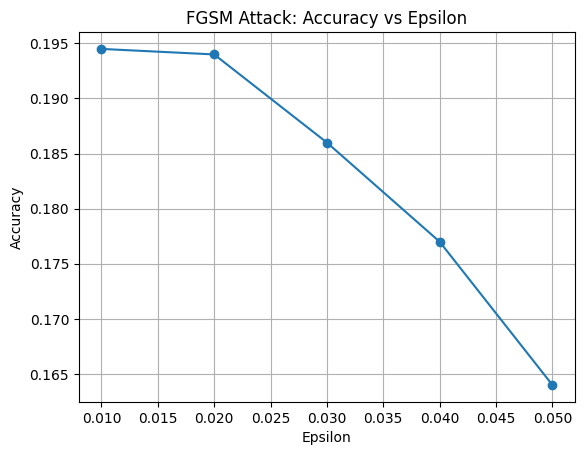

In [ ]:
import matplotlib.pyplot as plt

plt.figure()
plt.plot(fgsm_epsilons, fgsm_accuracies, marker='o')
plt.title("FGSM Attack: Accuracy vs Epsilon")
plt.xlabel("Epsilon")
plt.ylabel("Accuracy")
plt.grid(True)
plt.show()


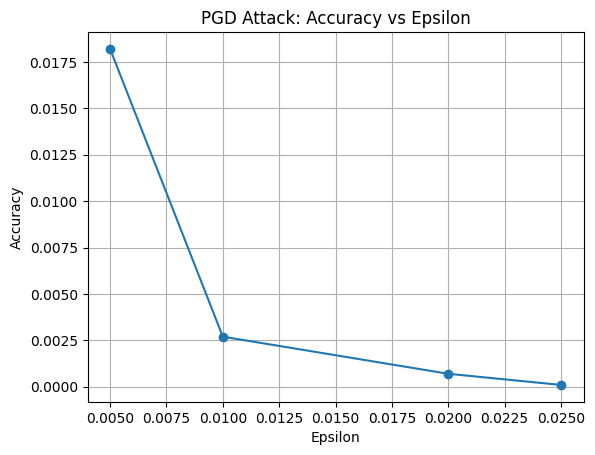

In [ ]:
import matplotlib.pyplot as plt

plt.figure()
plt.plot(pgd_epsilons, pgd_accuracies, marker='o')
plt.title("PGD Attack: Accuracy vs Epsilon")
plt.xlabel("Epsilon")
plt.ylabel("Accuracy")
plt.grid(True)
plt.show()


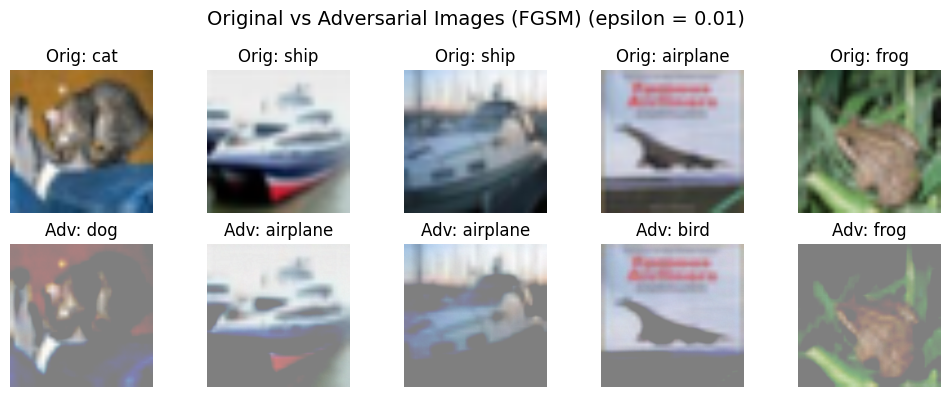

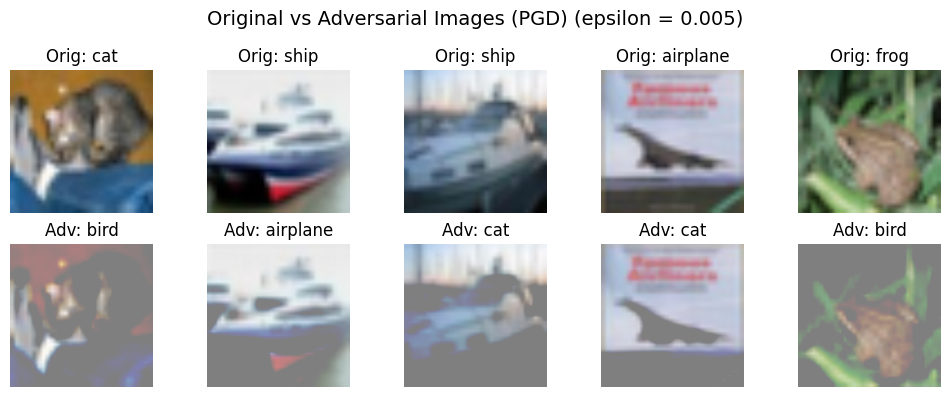

In [ ]:
import matplotlib.pyplot as plt
import numpy as np
import torch

cifar10_classes = [
    "airplane", "automobile", "bird", "cat", "deer",
    "dog", "frog", "horse", "ship", "truck"
]


def show_examples(epsilons, examples, attack_type):

  def imshow(img_tensor, title=None):
      img = img_tensor / 2 + 0.5  # unnormalize from [-1, 1] to [0, 1]
      npimg = img.numpy()
      plt.imshow(np.transpose(npimg, (1, 2, 0)))
      if title:
          plt.title(title)
      plt.axis('off')

  # Pick epsilon to visualize (e.g., epsilon = 0.05)
  epsilon_idx = 0  # or -1 for last epsilon
  example_data = examples[epsilon_idx]

  # Display first N examples
  N = min(5, len(example_data))
  plt.figure(figsize=(2 * N, 4))
  for i in range(N):
      orig_label, adv_label, orig_img, pert_img = example_data[i]

      orig_class = cifar10_classes[orig_label]
      adv_class = cifar10_classes[adv_label]

      # Original
      plt.subplot(2, N, i + 1)
      imshow(orig_img, title=f"Orig: {orig_class}")

      # Perturbed
      plt.subplot(2, N, i + 1 + N)
      imshow(pert_img, title=f"Adv: {adv_class}")

  plt.suptitle(f"Original vs Adversarial Images ({attack_type.upper()}) (epsilon = {epsilons[epsilon_idx]})", fontsize=14)
  plt.tight_layout()
  plt.show()

show_examples(fgsm_epsilons, fgsm_examples, attack_type="fgsm")
show_examples(pgd_epsilons, pgd_examples, attack_type="pgd")
